# Urban Semantic Segmentation Training

## steps:
* unzipping dataset file.
* creating the dataset class.
* training.
* evaluate.
* tesiting


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -U gdown

In [3]:
!gdown --id 1AZ9UGqRyrxzqSyfHC5mfRISgoQCvxuex --output semantic_segmentation_annotation.zip

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1AZ9UGqRyrxzqSyfHC5mfRISgoQCvxuex
To: /content/semantic_segmentation_annotation.zip
100% 9.66M/9.66M [00:00<00:00, 91.6MB/s]


In [4]:
!mkdir -p '/content/segmentation_data'

In [5]:
!unzip '/content/semantic_segmentation_annotation.zip' -d '/content/segmentation_data'

Archive:  /content/semantic_segmentation_annotation.zip
replace /content/segmentation_data/README.dataset.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/segmentation_data/README.dataset.txt  
replace /content/segmentation_data/README.roboflow.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/segmentation_data/README.roboflow.txt  
 extracting: /content/segmentation_data/train/-8f-PphflpZSDU6nqcv4hQ_jpg.rf.b473a8cbce236ef61bcc196a8471eb47.jpg  
  inflating: /content/segmentation_data/train/-8f-PphflpZSDU6nqcv4hQ_jpg.rf.b473a8cbce236ef61bcc196a8471eb47_mask.png  
 extracting: /content/segmentation_data/train/1-FjsQS2pNvMwNHyUsC1gQ_jpg.rf.87e9a96589ceb0aae25bb5d26b75078c.jpg  
  inflating: /content/segmentation_data/train/1-FjsQS2pNvMwNHyUsC1gQ_jpg.rf.87e9a96589ceb0aae25bb5d26b75078c_mask.png  
 extracting: /content/segmentation_data/train/1EDrn8pm-dWdpJB2Oe8NSQ_jpg.rf.77eb53240dc1be6fa5fba5d053001b53.jpg  
  inflating: /content/segmentation_data/train

### quick data investigation

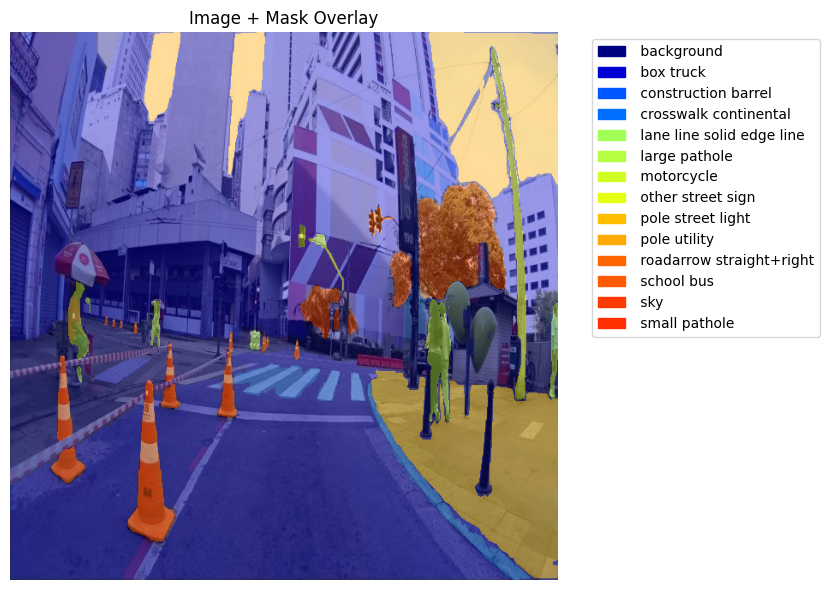

In [124]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import cv2


class_map = pd.read_csv('/content/segmentation_data/valid/_classes.csv')
class_map.columns = ['class_id', 'class_name']
id2label = dict(zip(class_map['class_id'], class_map['class_name']))
num_classes = len(id2label)

img_path = '/content/segmentation_data/train/-8f-PphflpZSDU6nqcv4hQ_jpg.rf.b473a8cbce236ef61bcc196a8471eb47.jpg'
mask_path = '/content/segmentation_data/train/-8f-PphflpZSDU6nqcv4hQ_jpg.rf.b473a8cbce236ef61bcc196a8471eb47_mask.png'

image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)


cmap = plt.get_cmap('jet', num_classes)
mask_rgb = np.zeros_like(image, dtype=np.float32)

for cls_id in np.unique(mask):
    if cls_id in id2label:
        color = np.array(cmap(cls_id)[:3]) * 255
        mask_rgb[mask == cls_id] = color

overlay = cv2.addWeighted(image.astype(np.float32), 0.6, mask_rgb, 0.4, 0).astype(np.uint8)

plt.figure(figsize=(10, 6))
plt.imshow(overlay)
plt.title("Image + Mask Overlay")
plt.axis('off')

handles = [mpatches.Patch(color=cmap(i), label=id2label[i]) for i in np.unique(mask) if i in id2label]
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


> **Notes:** After investigating the dataset i found the following:
- The dataset includes 149 jpg images (the dataset readme by roboflow mentioned 150)
- 112 training & 37 validation.
- The following pre-processing was applied to each
  image:
  * Auto-orientation of pixel data (with EXIF-orientation stripping)
  * Resize to 640x640 (Stretch)
- No image augmentation techniques were applied.
- Masks are in the same images folder saved as a png with the same name but ends with '_mask'.



In [6]:
!pip install torchvision albumentations segmentation-models-pytorch

In [7]:
import os
from glob import glob

import cv2
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler

from tqdm import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp
from segmentation_models_pytorch import Unet


### ensure same class maps for train and valid data

In [92]:
train_classes = pd.read_csv('/content/segmentation_data/train/_classes.csv')
valid_classes = pd.read_csv('/content/segmentation_data/valid/_classes.csv')

if train_classes.equals(valid_classes):
    print("Both classes.csv files are identical.")
else:
    print("classes.csv files are different. Investigate further.")


Both classes.csv files are identical.


In [93]:
class_map = pd.read_csv('/content/segmentation_data/train/_classes.csv')
num_classes = class_map.shape[0]
print(class_map)

    Pixel Value                   Class
0             0              background
1             1              18 wheeler
2             2               ambulance
3             3                   bench
4             4               billboard
..          ...                     ...
82           82          trash can city
83           83   trash can residential
84           84                    tree
85           85            tree cluster
86           86              yield sign

[87 rows x 2 columns]


In [94]:
train_images = sorted(glob('/content/segmentation_data/train/*.jpg'))
train_masks  = sorted(glob('/content/segmentation_data/train/*_mask.png'))
val_images   = sorted(glob('/content/segmentation_data/valid/*.jpg'))
val_masks    = sorted(glob('/content/segmentation_data/valid/*_mask.png'))


print(len(train_images))
print(len(train_masks))
print(len(val_images))
print(len(val_masks))

112
112
37
37


In [95]:
image_transform = A.Compose([
    A.Resize(640, 640),
    A.GaussianBlur(p=0.2),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

In [96]:
class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, image_transform):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.image_transform = image_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask  = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)

        augmented = self.image_transform(image=image, mask=mask)
        image = augmented['image']
        mask  = augmented['mask'].long()

        return image, mask

In [97]:
train_dataset = SegmentationDataset(train_images, train_masks, image_transform)
val_dataset = SegmentationDataset(val_images, val_masks, image_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

In [98]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.DeepLabV3(
    encoder_name='mobilenet_v2',
    encoder_weights='imagenet',
    in_channels=3,
    classes=num_classes
).to(device)


if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs")
    model = nn.DataParallel(model)


In [99]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [100]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
scaler = GradScaler()

<ipython-input-100-6658c84f97ee>:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [101]:
def train_one_epoch(model, loader, optimizer, loss_fn, device, scaler):
    model.train()
    running_loss = 0
    for imgs, masks in tqdm(loader):
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()

        with autocast():
            outputs = model(imgs)
            loss = loss_fn(outputs, masks)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
    return running_loss / len(loader)

def validate(model, loader, loss_fn, device):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            loss = loss_fn(preds, masks)
            val_loss += loss.item()
    return val_loss / len(loader)

In [102]:
num_epochs = 50
best_val_loss = float('inf')
patience = 5
patience_counter = 0
train_losses = []
val_losses = []

for epoch in range(num_epochs):

    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device, scaler)
    val_loss = validate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} — Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Saved best model at epoch {epoch+1} with val loss: {val_loss:.4f}")
    else:
        patience_counter += 1
        print(f"No improvement at epoch {epoch+1} — patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print("Early stopping triggered: No improvement for 5 consecutive epochs.")
            break


  0%|          | 0/14 [00:00<?, ?it/s]<ipython-input-101-b5f5cbc2637a>:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 14/14 [00:12<00:00,  1.15it/s]


Epoch 1/50 — Train Loss: 3.3245, Val Loss: 2.6713
Saved best model at epoch 1 with val loss: 2.6713


100%|██████████| 14/14 [00:12<00:00,  1.14it/s]


Epoch 2/50 — Train Loss: 2.2510, Val Loss: 2.1962
Saved best model at epoch 2 with val loss: 2.1962


100%|██████████| 14/14 [00:11<00:00,  1.18it/s]


Epoch 3/50 — Train Loss: 1.9418, Val Loss: 2.0415
Saved best model at epoch 3 with val loss: 2.0415


100%|██████████| 14/14 [00:11<00:00,  1.19it/s]


Epoch 4/50 — Train Loss: 1.7408, Val Loss: 1.9362
Saved best model at epoch 4 with val loss: 1.9362


100%|██████████| 14/14 [00:12<00:00,  1.16it/s]


Epoch 5/50 — Train Loss: 1.5569, Val Loss: 1.8582
Saved best model at epoch 5 with val loss: 1.8582


100%|██████████| 14/14 [00:11<00:00,  1.17it/s]


Epoch 6/50 — Train Loss: 1.4131, Val Loss: 1.7928
Saved best model at epoch 6 with val loss: 1.7928


100%|██████████| 14/14 [00:11<00:00,  1.17it/s]


Epoch 7/50 — Train Loss: 1.3044, Val Loss: 1.7373
Saved best model at epoch 7 with val loss: 1.7373


100%|██████████| 14/14 [00:11<00:00,  1.17it/s]


Epoch 8/50 — Train Loss: 1.2035, Val Loss: 1.6653
Saved best model at epoch 8 with val loss: 1.6653


100%|██████████| 14/14 [00:11<00:00,  1.17it/s]


Epoch 9/50 — Train Loss: 1.1389, Val Loss: 1.6134
Saved best model at epoch 9 with val loss: 1.6134


100%|██████████| 14/14 [00:12<00:00,  1.16it/s]


Epoch 10/50 — Train Loss: 1.0525, Val Loss: 1.5384
Saved best model at epoch 10 with val loss: 1.5384


100%|██████████| 14/14 [00:11<00:00,  1.17it/s]


Epoch 11/50 — Train Loss: 0.9550, Val Loss: 1.5300
Saved best model at epoch 11 with val loss: 1.5300


100%|██████████| 14/14 [00:11<00:00,  1.17it/s]


Epoch 12/50 — Train Loss: 0.8752, Val Loss: 1.4697
Saved best model at epoch 12 with val loss: 1.4697


100%|██████████| 14/14 [00:11<00:00,  1.17it/s]


Epoch 13/50 — Train Loss: 0.8105, Val Loss: 1.4657
Saved best model at epoch 13 with val loss: 1.4657


100%|██████████| 14/14 [00:11<00:00,  1.17it/s]


Epoch 14/50 — Train Loss: 0.7767, Val Loss: 1.4466
Saved best model at epoch 14 with val loss: 1.4466


100%|██████████| 14/14 [00:11<00:00,  1.17it/s]


Epoch 15/50 — Train Loss: 0.7384, Val Loss: 1.3975
Saved best model at epoch 15 with val loss: 1.3975


100%|██████████| 14/14 [00:11<00:00,  1.18it/s]


Epoch 16/50 — Train Loss: 0.6808, Val Loss: 1.3988
No improvement at epoch 16 — patience: 1/5


100%|██████████| 14/14 [00:11<00:00,  1.17it/s]


Epoch 17/50 — Train Loss: 0.6575, Val Loss: 1.3733
Saved best model at epoch 17 with val loss: 1.3733


100%|██████████| 14/14 [00:12<00:00,  1.16it/s]


Epoch 18/50 — Train Loss: 0.6124, Val Loss: 1.3943
No improvement at epoch 18 — patience: 1/5


100%|██████████| 14/14 [00:11<00:00,  1.18it/s]


Epoch 19/50 — Train Loss: 0.5941, Val Loss: 1.3768
No improvement at epoch 19 — patience: 2/5


100%|██████████| 14/14 [00:11<00:00,  1.18it/s]


Epoch 20/50 — Train Loss: 0.5750, Val Loss: 1.4045
No improvement at epoch 20 — patience: 3/5


100%|██████████| 14/14 [00:11<00:00,  1.18it/s]


Epoch 21/50 — Train Loss: 0.5572, Val Loss: 1.3380
Saved best model at epoch 21 with val loss: 1.3380


100%|██████████| 14/14 [00:11<00:00,  1.18it/s]


Epoch 22/50 — Train Loss: 0.5350, Val Loss: 1.3479
No improvement at epoch 22 — patience: 1/5


100%|██████████| 14/14 [00:12<00:00,  1.16it/s]


Epoch 23/50 — Train Loss: 0.5157, Val Loss: 1.3625
No improvement at epoch 23 — patience: 2/5


100%|██████████| 14/14 [00:11<00:00,  1.17it/s]


Epoch 24/50 — Train Loss: 0.5021, Val Loss: 1.3465
No improvement at epoch 24 — patience: 3/5


100%|██████████| 14/14 [00:11<00:00,  1.18it/s]


Epoch 25/50 — Train Loss: 0.4720, Val Loss: 1.3310
Saved best model at epoch 25 with val loss: 1.3310


100%|██████████| 14/14 [00:11<00:00,  1.18it/s]


Epoch 26/50 — Train Loss: 0.4513, Val Loss: 1.3262
Saved best model at epoch 26 with val loss: 1.3262


100%|██████████| 14/14 [00:11<00:00,  1.18it/s]


Epoch 27/50 — Train Loss: 0.4367, Val Loss: 1.3754
No improvement at epoch 27 — patience: 1/5


100%|██████████| 14/14 [00:11<00:00,  1.17it/s]


Epoch 28/50 — Train Loss: 0.4243, Val Loss: 1.3351
No improvement at epoch 28 — patience: 2/5


100%|██████████| 14/14 [00:11<00:00,  1.17it/s]


Epoch 29/50 — Train Loss: 0.4017, Val Loss: 1.3392
No improvement at epoch 29 — patience: 3/5


100%|██████████| 14/14 [00:12<00:00,  1.17it/s]


Epoch 30/50 — Train Loss: 0.3933, Val Loss: 1.3521
No improvement at epoch 30 — patience: 4/5


100%|██████████| 14/14 [00:11<00:00,  1.18it/s]


Epoch 31/50 — Train Loss: 0.3652, Val Loss: 1.3328
No improvement at epoch 31 — patience: 5/5
Early stopping triggered: No improvement for 5 consecutive epochs.


### Epoch 30/30 — Train Loss: 0.5657, Val Loss: 1.2706

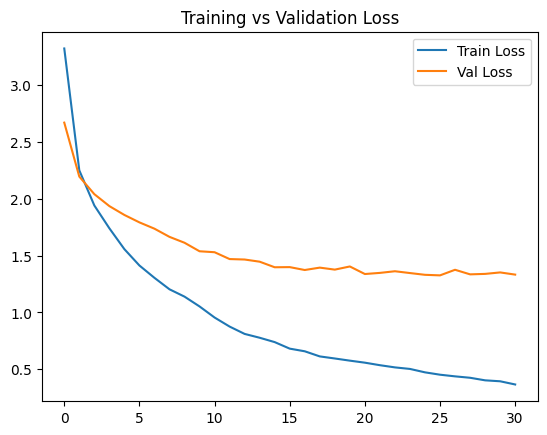

In [103]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

In [104]:
import pandas as pd
class_map = pd.read_csv('/content/segmentation_data/train/_classes.csv')
print(class_map.head())

   Pixel Value        Class
0            0   background
1            1   18 wheeler
2            2    ambulance
3            3        bench
4            4    billboard


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import cv2
import torch
import random

class_map = pd.read_csv('/content/segmentation_data/train/_classes.csv')
class_map.columns = ['class_id', 'class_name']
id2label = dict(zip(class_map['class_id'], class_map['class_name']))

def generate_random_color(seed=None):
    if seed is not None:
        random.seed(int(seed))
    return tuple(np.random.choice(range(50, 256), size=3))

def infer_and_visualize_segments(model, image_path):
    model.eval()


    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (640, 640))

    transformed = image_transform(image=img_resized)['image'].unsqueeze(0).to(device)
    with torch.no_grad():
        pred = model(transformed)
        pred_mask = torch.argmax(pred.squeeze(), dim=0).cpu().numpy()

    unique_classes = np.unique(pred_mask)
    class_colors = {cls_id: generate_random_color(seed=cls_id) for cls_id in unique_classes}

    mask_rgb = np.zeros_like(img_resized, dtype=np.uint8)
    for cls_id in unique_classes:
        mask_rgb[pred_mask == cls_id] = class_colors[cls_id]


    blended = cv2.addWeighted(img_resized.astype(np.uint8), 0.7, mask_rgb, 0.3, 0)


    plt.figure(figsize=(10, 6))
    plt.imshow(blended)
    plt.title("Overlay: Prediction on Resized Image")
    plt.axis('off')

    handles = [
        mpatches.Patch(color=np.array(class_colors[i]) / 255.0, label=id2label.get(i, f'class {i}'))
        for i in unique_classes
    ]
    plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


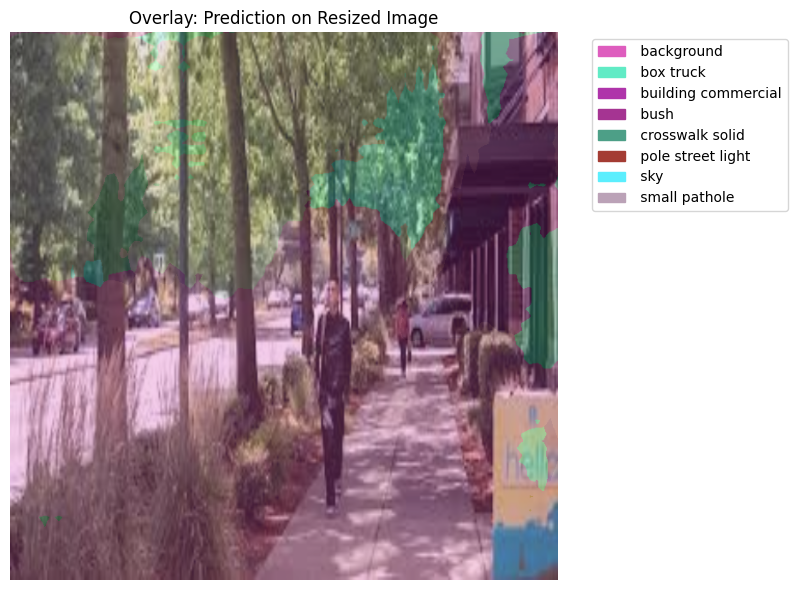

In [126]:
infer_and_visualize_segments(model= model, image_path='/content/image.jpeg')